List of theoretical Brown Dwarf (BD) cooling models found in literature:

- [AMES-Dusty 2000](https://cds.cern.ch/record/440166/files/0005557.pdf)
- [AMES-Cond 2003](https://www.aanda.org/articles/aa/pdf/2003/17/aa3343.pdf)
- [Saumon & Marley '08 (SM08)](https://arxiv.org/abs/0808.2611)
- [BT-Settl Model 2014](https://ui.adsabs.harvard.edu/abs/2014IAUS..299..271A/abstract) and [this](https://ui.adsabs.harvard.edu/abs/2014ASInC..11...33A/abstract)
- [Fernandes + '19](https://arxiv.org/pdf/1906.05626.pdf)
- [ATMO 2020](https://arxiv.org/abs/2003.13717), data can be found  [here](http://perso.ens-lyon.fr/isabelle.baraffe/ATMO2020/)
- [Sonora](https://arxiv.org/pdf/2107.07434.pdf) --> section 2.6: brief review of models in literature
- [Sonora Cholla](https://arxiv.org/pdf/2110.11824.pdf), effect of atmosphere in disequilibria

Apparently there are two families of models: those of the Lyon group and those of the Saumon & Marley group

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.constants import c, R_jup, M_jup, G, GM_jup, sigma_sb, M_sun, L_sun, R_sun
import astropy.units as u
from scipy.interpolate import interp1d, interp2d, griddata
import cmocean
from scipy.stats import loguniform
import sys
sys.path.append("../python/")
from utils import temperature, heat, temperature_withDM
import bokeh.palettes
import _corner
import imp
imp.reload(_corner)
from _corner import corner
import pickle
from scipy.stats import gaussian_kde
import glob

from matplotlib import rc
rc('font', family='times new roman', size=18.)

## Saumon & Marley '08 (fig 2)

In [2]:
age  = {}
logL = {}
L    = {}
M    = [0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]
Teff = {}

evolution_SM08 = {}
path = "/home/mariacst/exoplanets/exoplanets/data/evolution_models/"

for mass in M:
    data = np.genfromtxt(path + "SM08/saumon_marley_fig2_" + str(mass) + ".dat", unpack=True)
    age[mass]  = data[0]
    logL[mass] = data[1]
    L[mass]    = np.power(10, data[1])*L_sun
    Teff[mass] = temperature(L[mass], R_jup)
    
    evolution_SM08[mass] = [10**data[0], Teff[mass], data[1]]
    
    
log_age  = np.linspace(6.1, 9.9, 10)
_log_age = []
_mass    = []
_teff    = []

for m in M:
    Teff_interp = interp1d(age[m], Teff[m])
    for lage in log_age:
        _log_age.append(lage)
        _mass.append(m)
        _teff.append(Teff_interp(lage))

Teff_interp_2d = interp2d(_log_age, _mass, _teff)
_teff = np.asarray(_teff)

191.9765782571303 9198.842056939638


Text(0.5, 0, 'log(age) [yr]')

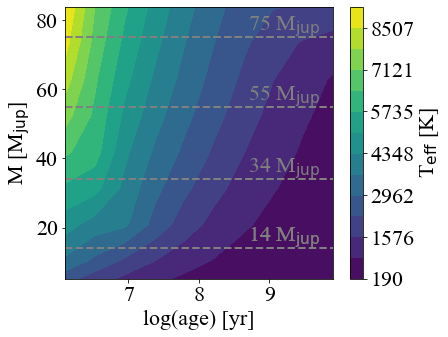

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

Z = _teff.reshape(len(M), len(log_age))

M_in_jup = M*M_sun/M_jup

X, Y = np.meshgrid(log_age, M_in_jup)

#levels = np.linspace(np.min(_teff), np.max(_teff), 14)
levels = np.linspace(190, 9200, 14)
print(np.min(_teff), np.max(_teff))

cs = ax.contourf(X, Y, Z, levels=levels)
cbar = fig.colorbar(cs)
cbar.set_label(r"T$_{\rm eff}$ [K]")
ax.axhline(14, color="grey", ls="--", lw=2.)
ax.text(8.7, 77, r"75 M$_{\rm jup}$", color="grey")
ax.text(8.7, 16, r"14 M$_{\rm jup}$", color="grey")
ax.axhline(75, color="grey", ls="--", lw=2.)

ax.text(8.7, 16, r"14 M$_{\rm jup}$", color="grey")
ax.axhline(75, color="grey", ls="--", lw=2.)
ax.text(8.7, 36, r"34 M$_{\rm jup}$", color="grey")
ax.axhline(34, color="grey", ls="--", lw=2.)
ax.text(8.7, 57, r"55 M$_{\rm jup}$", color="grey")
ax.axhline(55, color="grey", ls="--", lw=2.)
#ax.axvline(np.log10(1*10**9))
#ax.axvline(np.log10(2*10**9))
#ax.axvline(np.log10(4.1*10**9))
#ax.axvline(np.log10(8.3*10**9))

ax.set_ylabel(r"M [M$_{\rm jup}$]")
ax.set_xlabel("log(age) [yr]")

#fig.savefig("../Figs/BD_model_1.pdf", bbox_inches="tight")

(6.0, 10.0)

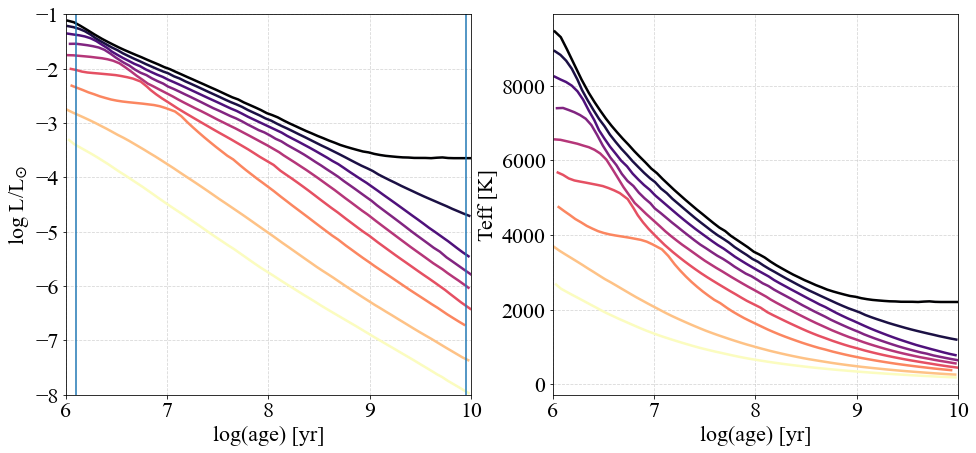

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(16, 7))

colors = bokeh.palettes.magma(len(M))
colors = colors[::-1] # reverse tuple

i = 0
for mass in M:
    ax[0].plot(age[mass], logL[mass], color=colors[i], lw=2.5)
    ax[1].plot(age[mass], Teff[mass], color=colors[i], lw=2.5)
    i = i+1

ax[0].set_ylabel("log L/L$_{\odot}$")
ax[0].set_xlabel("log(age) [yr]")
ax[0].grid(which="both", ls="--", alpha=0.5)
ax[0].set_ylim([-8, -1])
ax[0].set_xlim([6, 10])
ax[0].axvline(6.1)
ax[0].axvline(9.95)

ax[1].set_ylabel("Teff [K]")
ax[1].set_xlabel("log(age) [yr]")
ax[1].grid(which="both", ls="--", alpha=0.5)
ax[1].set_xlim([6, 10])

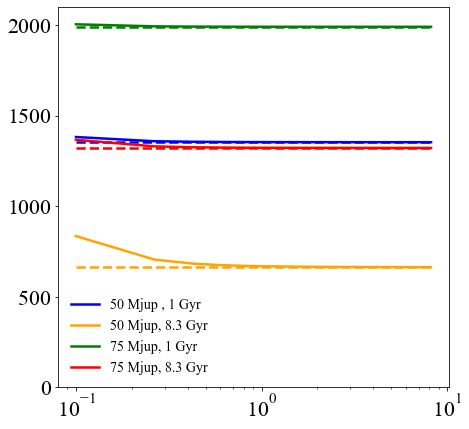

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

r = np.linspace(0.1, 8.178, 50)
m = 50.*M_jup; l_age = 9.
h_int = heat(Teff_interp_2d(l_age, m/M_sun), R_jup.value)
t = temperature_withDM(r, h_int, f=1, R=R_jup.value, M=m, parameters=[1, 20, 0.42])
ax.plot(r, t, label="50 Mjup , 1 Gyr", lw=2.5, color="blue")
ax.plot(r, np.ones(len(r))*Teff_interp_2d(l_age, m/M_sun), ls="--", lw=2.5, color="blue")

m = 50.*M_jup; l_age = 9.92
h_int = heat(Teff_interp_2d(l_age, m/M_sun), R_jup.value)
t = temperature_withDM(r, h_int, f=1, R=R_jup.value, M=m, parameters=[1, 20, 0.42])
ax.plot(r, t, label="50 Mjup, 8.3 Gyr", lw=2.5, color="orange")
ax.plot(r, np.ones(len(r))*Teff_interp_2d(l_age, m/M_sun), ls="--", lw=2.5, color="orange")

m = 75.*M_jup; l_age = 9.
h_int = heat(Teff_interp_2d(l_age, m/M_sun), R_jup.value)
t = temperature_withDM(r, h_int, f=1, R=R_jup.value, M=m, parameters=[1, 20, 0.42])
ax.plot(r, t, label="75 Mjup, 1 Gyr", lw=2.5, color="green")
ax.plot(r, np.ones(len(r))*Teff_interp_2d(l_age, m/M_sun), ls="--", lw=2.5, color="green")

m = 75.*M_jup; l_age = 9.92
h_int = heat(Teff_interp_2d(l_age, m/M_sun), R_jup.value)
t = temperature_withDM(r, h_int, f=1, R=R_jup.value, M=m, parameters=[1, 20, 0.42])
ax.plot(r, t, label="75 Mjup, 8.3 Gyr", lw=2.5, color="red")
ax.plot(r, np.ones(len(r))*Teff_interp_2d(l_age, m/M_sun), ls="--", lw=2.5, color="red")

ax.legend(frameon=False, fontsize=14)
ax.set_ylim([0, 2100])
ax.set_xscale("log")

## ATMO 2020

In [2]:
path   = "../data/evolution_models/ATMO_2020_models/evolutionary_tracks/"
models = ["ATMO_CEQ/", "ATMO_NEQ_strong/", "ATMO_NEQ_weak/"]

evolution_ATMO20      = {}
evolution_ATMO20["M"] = []
for model in models:
    evolution_ATMO20[model] = {}
    files = glob.glob(path + model + "*.txt")
    for file in files:
        data = np.genfromtxt(file, unpack=True)
        evolution_ATMO20[model][data[0][0]] = [data[1], data[2], data[3], data[4], data[5]] 
        # age [Gyr] / Teff [K] / L [L/Lsun] / R [R/Rsun] / log g [cm/s2]
        if model==models[0]:
            #print (data[0][0], file)
            evolution_ATMO20["M"].append(data[0][0])

Text(0, 0.5, 'T$_{\\rm eff}$ [K]')

findfont: Font family ['times new roman'] not found. Falling back to DejaVu Sans.


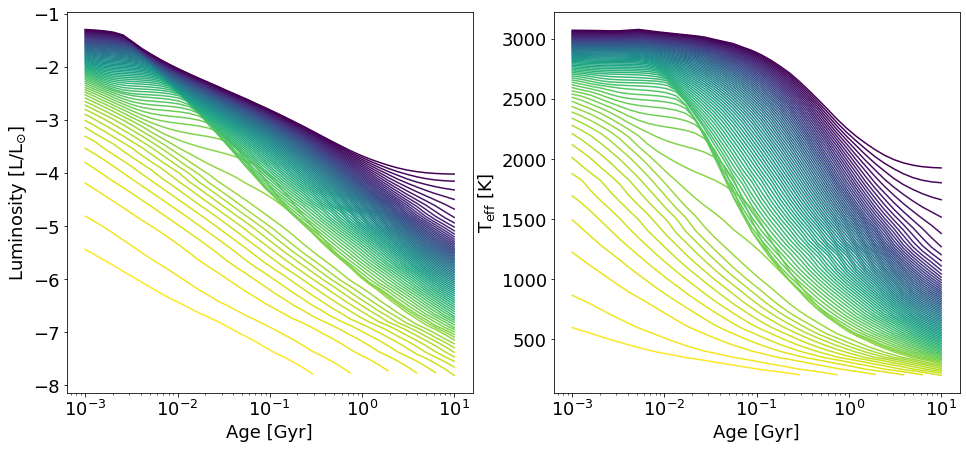

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(16, 7))

i     = 0
ls    = ["-", "--", ":"]
color = bokeh.palettes.viridis(len(evolution_ATMO20["M"]))
color = color[::-1]

models = ["ATMO_CEQ/"]#, "ATMO_NEQ_strong/", "ATMO_NEQ_weak/"]
masses = np.sort(np.asarray(evolution_ATMO20["M"]))

for model in models:
    j = 0
    for mass in masses:
        #if (np.abs(mass-0.06) < 0.009) or (np.abs(mass-0.07) < 0.009):
        #    print(mass)
        #    continue
        ax[0].plot(evolution_ATMO20[model][mass][0], evolution_ATMO20[model][mass][2], ls=ls[i], color=color[j])
        ax[1].plot(evolution_ATMO20[model][mass][0], evolution_ATMO20[model][mass][1], ls=ls[i], color=color[j])
        j = j+1
    i = i+1
        
ax[0].set_xlabel("Age [Gyr]")
ax[0].set_xscale("log")
ax[0].set_ylabel(r"Luminosity [L/L$_{\odot}$]")
ax[1].set_xlabel("Age [Gyr]")
ax[1].set_xscale("log")
ax[1].set_ylabel(r"T$_{\rm eff}$ [K]")

In [4]:
masses = np.sort(np.asarray(evolution_ATMO20["M"]))
pos    = np.where((masses > 0.014) & (masses < 0.052))
masses = masses[pos]
#print(masses)

ages = evolution_ATMO20["ATMO_CEQ/"][masses[0]][0]
Teff  = {}

for i in range(len(ages)):
    Teff[ages[i]] = []
    for mass in masses:
        Teff[ages[i]].append(evolution_ATMO20["ATMO_CEQ/"][mass][1][i])

In [47]:
print(np.sort(np.asarray(evolution_ATMO20["M"]))*M_sun/M_jup)

index = [15, 30, 53, 67]
print(np.sort(np.asarray(evolution_ATMO20["M"]))[index]*M_sun/M_jup)

masses = np.sort(np.asarray(evolution_ATMO20["M"]))[index]

[ 0.52378276  1.04756551  2.09513103  3.14269654  4.19026206  5.23782757
  6.28539309  7.3329586   8.38052412  9.42808963 10.47565515 11.52322066
 12.57078618 13.61835169 14.66591721 15.71348272 16.76104823 17.80861375
 18.85617926 19.90374478 20.95131029 21.99887581 23.04644132 24.09400684
 25.14157235 26.18913787 27.23670338 28.2842689  29.33183441 30.37939993
 31.42696544 32.47453095 33.52209647 34.56966198 35.6172275  36.66479301
 37.71235853 38.75992404 39.80748956 40.85505507 41.90262059 42.9501861
 43.99775162 45.04531713 46.09288265 47.14044816 48.18801367 49.23557919
 50.2831447  51.33071022 52.37827573 53.42584125 54.47340676 55.52097228
 56.56853779 57.61610331 58.66366882 59.71123434 60.75879985 61.80636536
 62.85393088 63.90149639 64.94906191 65.99662742 67.04419294 68.09175845
 69.13932397 70.18688948 71.234455   72.28202051 73.32958603 74.37715154
 75.42471706 76.47228257 77.51984808 78.5674136 ]
[15.71348272 31.42696544 55.52097228 70.18688948]


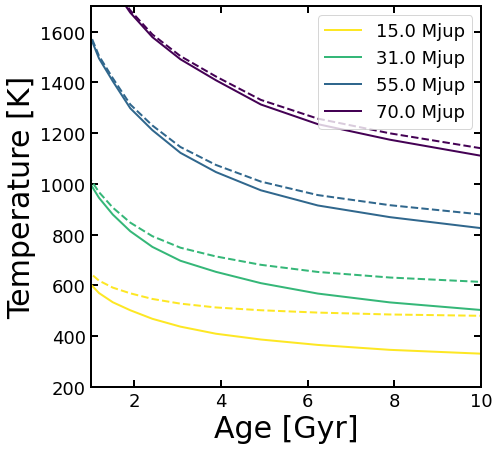

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

i     = 0
ls    = ["-", "--", ":"]
color = bokeh.palettes.viridis(len(masses))
color = color[::-1]

conv_Msun_to_kg = 1.98841e+30   

models = ["ATMO_CEQ/"]#, "ATMO_NEQ_strong/", "ATMO_NEQ_weak/"]
for model in models:
    j = 0
    for mass in masses:
        ax.plot(evolution_ATMO20[model][mass][0], evolution_ATMO20[model][mass][1], 
                ls=ls[i], color=color[j], lw=2., label="{} Mjup".format(np.floor(mass*M_sun/M_jup)))
        
        Tmodel = temperature_withDM(0.1, evolution_ATMO20[model][mass][1], M=mass*conv_Msun_to_kg, v=100)
        
        ax.plot(evolution_ATMO20[model][mass][0], Tmodel, ls="--", color=color[j], lw=2.)
        
        j = j+1
    i = i+1 

ax.set_xlabel("Age [Gyr]", fontsize=30)
ax.set_xlim([1, 10]); ax.set_ylim([200, 1700])
ax.set_ylabel(r"Temperature [K]", fontsize=30) 
ax.legend(loc="best")


for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2.);
        
ax.tick_params(which='major',direction="in",width=2.,length=7,right=True,top=True,pad=5)

fig.savefig("ATMO_T_vs_A_withDM.pdf", bbox_inches="tight")

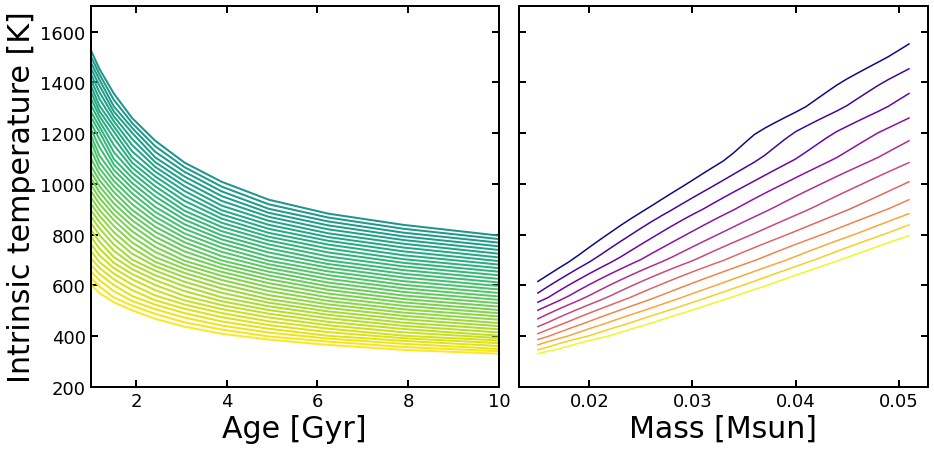

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7), sharey=True)

i     = 0
ls    = ["-", "--", ":"]
color = bokeh.palettes.viridis(len(evolution_ATMO20["M"]))
color = color[::-1]

models = ["ATMO_CEQ/"]#, "ATMO_NEQ_strong/", "ATMO_NEQ_weak/"]
for model in models:
    j = 0
    for mass in masses:
        #if (np.abs(mass-0.06) < 0.009) or (np.abs(mass-0.07) < 0.009):
        #    print(mass)
        #    continue
        ax[0].plot(evolution_ATMO20[model][mass][0], evolution_ATMO20[model][mass][1], 
                ls=ls[i], color=color[j], lw=2.)
        j = j+1
    i = i+1
ax[0].set_xlabel("Age [Gyr]", fontsize=30)
#ax[0].set_xscale("log"); ax[0].set_yscale("log")
ax[0].set_xlim([1, 10]); ax[0].set_ylim([200, 1700])
ax[0].set_ylabel(r"Intrinsic temperature [K]", fontsize=30) 


pos  = np.where((ages > 0.9) & (ages < 10.5))
ages = ages[pos]

color = bokeh.palettes.plasma(len(ages))
i=0

for age in ages:
    ax[1].plot(masses, Teff[age], color=color[i])
    i+=1        
ax[1].set_xlabel("Mass [Msun]", fontsize=30)

for axis in ['top','bottom','left','right']:
        ax[0].spines[axis].set_linewidth(2.); ax[1].spines[axis].set_linewidth(2.)
        
ax[0].tick_params(which='major',direction="in",width=2.,length=7,right=True,top=True,pad=5)
ax[1].tick_params(which='major',direction="in",width=2.,length=7,right=True,top=True,pad=5)

fig.subplots_adjust(wspace=0.05)
#fig.savefig("ATMO_model_masses.pdf", bbox_inches="tight")

IndexError: tuple index out of range

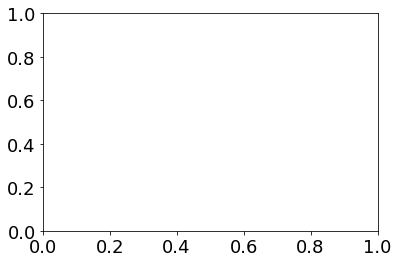

In [59]:
fig, ax = plt.subplots()
ax.plot(masses, Teff[ages[3]], color=color[i])

In [61]:
ages[3]

1.91448198

200.34531482 1905.1223504655072


findfont: Font family ['times new roman'] not found. Falling back to DejaVu Sans.


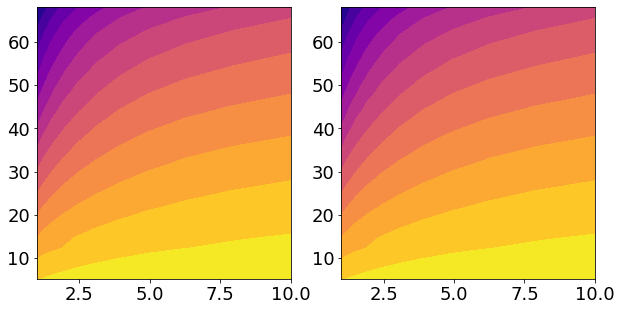

In [6]:
model = "ATMO_CEQ/"
age   = {}
M     = np.sort(evolution_ATMO20["M"])[5:-10] # the first 5 masses do not have all values between 1 and 10 Gyr
Teff  = {}

for mass in M:
    age[mass]  = evolution_ATMO20[model][mass][0]
    Teff[mass] = evolution_ATMO20[model][mass][1]

_age   = np.linspace(1, 10, 80)    
_teff  = [] ; _age_i = []; _mass  = []
for m in M:
    Teff_interp = interp1d(age[m], Teff[m])
    for _a in _age:
        _age_i.append(_a)
        _mass.append(m)
        _teff.append(Teff_interp(_a))

points = np.transpose(np.asarray([_age_i, _mass]))
values = np.asarray(_teff)

x, y = np.meshgrid(_age, M)

Teff_interp_2d = griddata(points, values , (x, y))

_teff = np.asarray(_teff)


fig, ax = plt.subplots(1, 2, figsize=(10, 5))

Z = _teff.reshape(len(M), len(_age))
M_in_jup = M*M_sun/M_jup
X, Y = np.meshgrid(_age, M_in_jup)

levels = np.linspace(np.min(_teff), np.max(_teff), 14)
print(np.min(_teff), np.max(_teff))

cs = ax[0].contourf(X, Y, Z, levels=levels, cmap="plasma_r")

ax[1].contourf(X, Y, Teff_interp_2d, levels=levels, cmap="plasma_r")

In [7]:
pos = np.where((np.abs(Y-44.)<0.5) & (X==1.))
print(Y[pos], X[pos])
print(Teff_interp_2d[pos])

[43.99775162] [1.]
[1313.35445654]


/home/mariacst/exoplanets/.venv/lib64/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=88,73 m=6100 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


200.34531482 1905.1223504655072


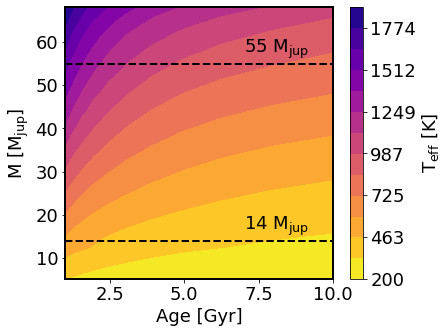

In [33]:
model = "ATMO_CEQ/"
age   = {}
M     = np.sort(evolution_ATMO20["M"])[5:-10] # the first 5 masses do not have all values between 1 and 10 Gyr
Teff  = {}

for mass in M:
    age[mass]  = evolution_ATMO20[model][mass][0]
    Teff[mass] = evolution_ATMO20[model][mass][1]

_age   = np.linspace(1, 10, 100)    
_teff  = [] ; _age_i = []; _mass  = []
for m in M:
    Teff_interp = interp1d(age[m], Teff[m])
    for _a in _age:
        _age_i.append(_a)
        _mass.append(m)
        _teff.append(Teff_interp(_a))
        
Teff_interp_2d = interp2d(_age_i, _mass, _teff)
_teff = np.asarray(_teff)


fig, ax = plt.subplots(1, 1, figsize=(6, 5))

Z = _teff.reshape(len(M), len(_age))
M_in_jup = M*M_sun/M_jup
X, Y = np.meshgrid(_age, M_in_jup)

levels = np.linspace(np.min(_teff), np.max(_teff), 14)
print(np.min(_teff), np.max(_teff))

cs = ax.contourf(X, Y, Z, levels=levels, cmap="plasma_r")
cbar = fig.colorbar(cs)
cbar.set_label(r"T$_{\rm eff}$ [K]")
ax.axhline(14, color="k", ls="--", lw=2.)
ax.text(7., 16.5, r"14 M$_{\rm jup}$", color="k")
ax.text(7., 57.5, r"55 M$_{\rm jup}$", color="k")
ax.axhline(55, color="k", ls="--", lw=2.)

ax.set_ylabel(r"M [M$_{\rm jup}$]")
ax.set_xlabel("Age [Gyr]")

for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2.)

fig.savefig("ATMO2020_cooling_model.pdf", bbox_inches="tight")

In [12]:
model = "ATMO_CEQ/"
age   = {}
M     = np.sort(evolution_ATMO20["M"])[5:-10] # the first 5 masses do not have all values between 1 and 10 Gyr
Teff  = {}

for mass in M:
    age[mass]  = evolution_ATMO20[model][mass][0]
    Teff[mass] = evolution_ATMO20[model][mass][1]

_age   = np.linspace(1, 10, 100)    
_teff  = [] ; _age_i = []; _mass  = []
for m in M:
    Teff_interp = interp1d(age[m], Teff[m])
    for _a in _age:
        _age_i.append(_a)
        _mass.append(m)
        _teff.append(Teff_interp(_a))
        
Teff_interp_2d = interp2d(_age_i, _mass, _teff)
_teff = np.asarray(_teff)

In [20]:
# convert K into C
_teff_inC = _teff - 273.15

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


-72.80468517999998 1631.9723504655071


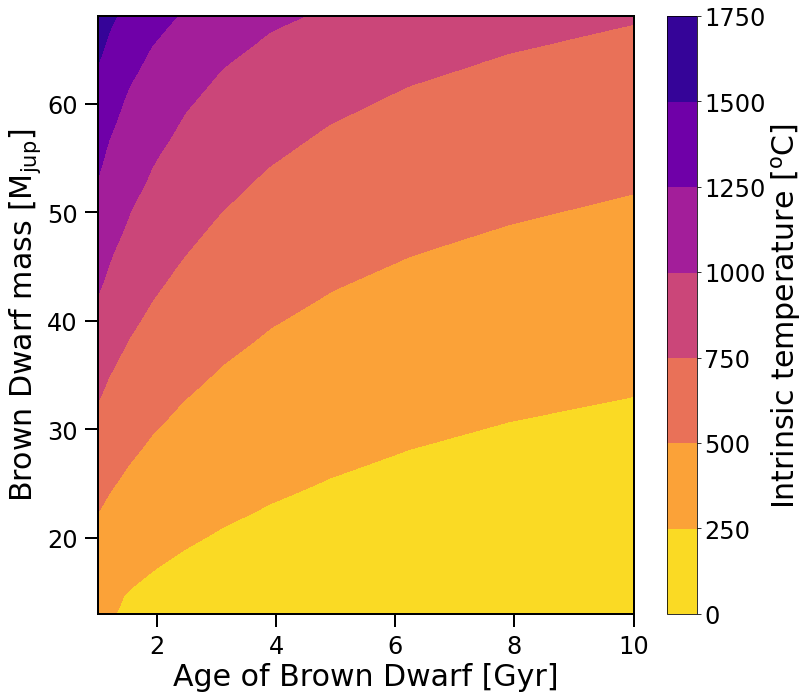

In [47]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino'], 'size':24})

fig, ax = plt.subplots(1, 1, figsize=(12, 11))

ax.tick_params(which='major',direction="out",width=2.,length=13,right=False,top=False,pad=7)


Z = _teff_inC.reshape(len(M), len(_age))
M_in_jup = M*M_sun/M_jup
X, Y = np.meshgrid(_age, M_in_jup)

pos = np.where(X>13)

levels = np.linspace(0, 1750, 8)
print(np.min(_teff_inC), np.max(_teff_inC))

cs = ax.contourf(X, Y, Z, levels=levels, cmap="plasma_r")
cbar = fig.colorbar(cs)
cbar.set_label(r"Intrinsic temperature [$^{\rm o}$C]", fontsize=30)

ax.set_ylabel(r"Brown Dwarf mass [M$_{\rm jup}$]", fontsize=30)
ax.set_xlabel("Age of Brown Dwarf [Gyr]", fontsize=30)

ax.set_ylim(13, np.max(Y))

for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2.)
#fig.savefig("ATMO_model_celsius.pdf", bbox_inches="tight")

200.34531482 1905.1223504655072


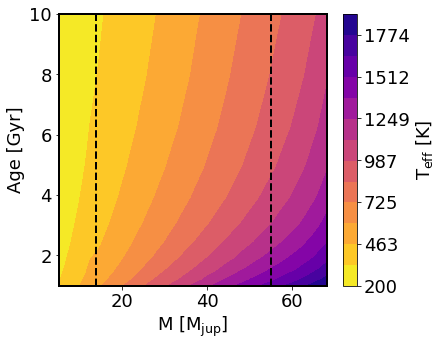

In [7]:
model = "ATMO_CEQ/"
age   = {}
M     = np.sort(evolution_ATMO20["M"])[5:-10] # the first 5 masses do not have all values between 1 and 10 Gyr
Teff  = {}

for mass in M:
    age[mass]  = evolution_ATMO20[model][mass][0]
    Teff[mass] = evolution_ATMO20[model][mass][1]

_age   = np.linspace(1, 10, 100)    
_teff  = [] ; _age_i = []; _mass  = []
for m in M:
    Teff_interp = interp1d(age[m], Teff[m])
    for _a in _age:
        _age_i.append(_a)
        _mass.append(m)
        _teff.append(Teff_interp(_a))
        
Teff_interp_2d = interp2d(_age_i, _mass, _teff)
_teff = np.asarray(_teff)


fig, ax = plt.subplots(1, 1, figsize=(6, 5))

Z = _teff.reshape(len(M), len(_age))
M_in_jup = M*M_sun/M_jup
X, Y = np.meshgrid(M_in_jup, _age)

levels = np.linspace(np.min(_teff), np.max(_teff), 14)
print(np.min(_teff), np.max(_teff))

cs = ax.contourf(X, Y, Z.T, levels=levels, cmap="plasma_r")
cbar = fig.colorbar(cs)
cbar.set_label(r"T$_{\rm eff}$ [K]")
ax.axvline(14, color="k", ls="--", lw=2.)
#ax.text(7., 16.5, r"14 M$_{\rm jup}$", color="k")
#ax.text(7., 57.5, r"55 M$_{\rm jup}$", color="k")
ax.axvline(55, color="k", ls="--", lw=2.)

ax.set_xlabel(r"M [M$_{\rm jup}$]")
ax.set_ylabel("Age [Gyr]")

for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2.)

#fig.savefig("../Figs/ATMO2020_cooling_model.pdf", bbox_inches="tight")

In [18]:
pos = np.where(Z >= 650.)
print(pos, Z.shape, Z[pos].shape)

(array([12, 13, 13, ..., 60, 60, 60]), array([ 0,  0,  1, ..., 97, 98, 99])) (61, 100) (3312,)


/home/mariacst/exoplanets/.venv/lib64/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=88,73 m=6100 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


200.34531482 1905.1223504655072


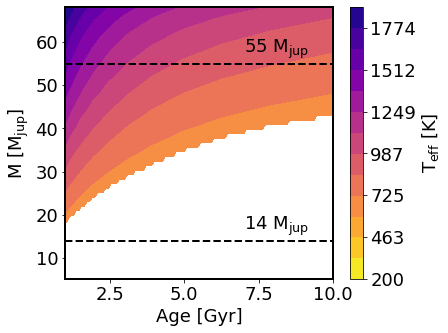

In [25]:
model = "ATMO_CEQ/"
age   = {}
M     = np.sort(evolution_ATMO20["M"])[5:-10] # the first 5 masses do not have all values between 1 and 10 Gyr
Teff  = {}

for mass in M:
    age[mass]  = evolution_ATMO20[model][mass][0]
    Teff[mass] = evolution_ATMO20[model][mass][1]

_age   = np.linspace(1, 10, 100)    
_teff  = [] ; _age_i = []; _mass  = []
for m in M:
    Teff_interp = interp1d(age[m], Teff[m])
    for _a in _age:
        _age_i.append(_a)
        _mass.append(m)
        _teff.append(Teff_interp(_a))
        
Teff_interp_2d = interp2d(_age_i, _mass, _teff)
_teff = np.asarray(_teff)


fig, ax = plt.subplots(1, 1, figsize=(6, 5))

Z = _teff.reshape(len(M), len(_age))
M_in_jup = M*M_sun/M_jup
X, Y = np.meshgrid(_age, M_in_jup)

levels = np.linspace(np.min(_teff), np.max(_teff), 14)
print(np.min(_teff), np.max(_teff))


Z = np.ma.array(Z, mask=Z < 650.)
cs = ax.contourf(X, Y, Z, levels=levels, cmap="plasma_r")
cbar = fig.colorbar(cs)
cbar.set_label(r"T$_{\rm eff}$ [K]")
ax.axhline(14, color="k", ls="--", lw=2.)
ax.text(7., 16.5, r"14 M$_{\rm jup}$", color="k")
ax.text(7., 57.5, r"55 M$_{\rm jup}$", color="k")
ax.axhline(55, color="k", ls="--", lw=2.)

ax.set_ylabel(r"M [M$_{\rm jup}$]")
ax.set_xlabel("Age [Gyr]")

for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2.)

fig.savefig("/home/mariacst/exoplanets/Figs/ATMO2020_cooling_model_mask650.pdf", bbox_inches="tight")

In [ ]:
model = "ATMO_CEQ/"
age   = {}
M     = np.sort(evolution_ATMO20["M"])[5:-10] # the first 5 masses do not have all values between 1 and 10 Gyr
Teff  = {}

for mass in M:
    age[mass]  = evolution_ATMO20[model][mass][0]
    Teff[mass] = evolution_ATMO20[model][mass][1]

_age   = np.linspace(1, 10, 100)    
_teff  = [] ; _age_i = []; _mass  = []
for m in M:
    Teff_interp = interp1d(age[m], Teff[m])
    for _a in _age:
        _age_i.append(_a)
        _mass.append(m)
        _teff.append(Teff_interp(_a))
        
Teff_interp_2d = interp2d(_age_i, _mass, _teff)
_teff = np.asarray(_teff)


fig, ax = plt.subplots(1, 1, figsize=(6, 5))

Z = _teff.reshape(len(M), len(_age))
M_in_jup = M*M_sun/M_jup
X, Y = np.meshgrid(_age, M_in_jup)

levels = np.linspace(np.min(_teff), np.max(_teff), 14)
print(np.min(_teff), np.max(_teff))

cs = ax.contourf(X, Y, Z, levels=levels, cmap="plasma_r")
cbar = fig.colorbar(cs)
cbar.set_label(r"T$_{\rm eff}$ [K]")
ax.axhline(14, color="k", ls="--", lw=2.)
ax.text(7., 16.5, r"14 M$_{\rm jup}$", color="k")
ax.text(7., 57.5, r"55 M$_{\rm jup}$", color="k")
ax.axhline(55, color="k", ls="--", lw=2.)

ax.set_ylabel(r"M [M$_{\rm jup}$]")
ax.set_xlabel("Age [Gyr]")

for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2.)

#fig.savefig("../Figs/ATMO2020_cooling_model.pdf", bbox_inches="tight")

In [71]:
model = "ATMO_CEQ/"
age   = {}
M     = np.sort(evolution_ATMO20["M"])[5:-10] # the first 5 masses do not have all values between 1 and 10 Gyr
Teff  = {}

for mass in M:
    age[mass]  = evolution_ATMO20[model][mass][0]
    Teff[mass] = evolution_ATMO20[model][mass][1]

_age   = np.linspace(1, 10, 100)    
_teff  = [] ; _age_i = []; _mass  = []
for m in M:
    Teff_interp = interp1d(age[m], Teff[m])
    for _a in _age:
        _age_i.append(_a)
        _mass.append(m)
        _teff.append(Teff_interp(_a))
        
points = np.transpose(np.asarray([_age_i, _mass]))
values = np.asarray(_teff)

_age = _age[0:len(M)]
print(_age.shape, M.shape)
xi = np.transpose(np.asarray([_age, M]))

Teff_interp_2d = griddata(points, values , xi)

(61,) (61,)


Text(0, 0.5, 'Radius [$\\rm R_{Jup}$]')

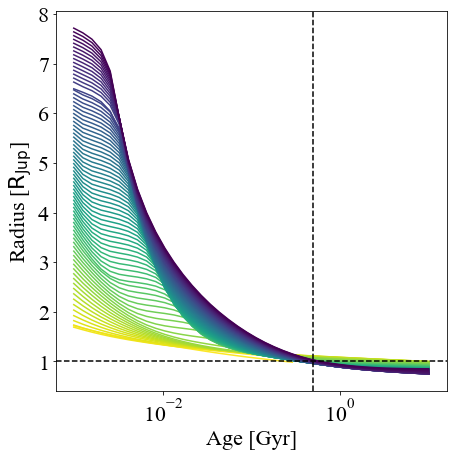

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

i     = 0
ls    = ["-", "--", ":"]
color = bokeh.palettes.viridis(len(evolution_ATMO20["M"]))
color = color[::-1]

models = ["ATMO_CEQ/"]#, "ATMO_NEQ_strong/", "ATMO_NEQ_weak/"]
masses = np.sort(np.asarray(evolution_ATMO20["M"]))

for model in models:
    j = 0
    for mass in masses:
        #if (np.abs(mass-0.06) < 0.009) or (np.abs(mass-0.07) < 0.009):
        #    print(mass)
        #    continue
        ax.plot(evolution_ATMO20[model][mass][0], evolution_ATMO20[model][mass][3]*R_sun/R_jup, 
                ls=ls[i], color=color[j])
        j = j+1
    i = i+1

ax.axvline(0.5, color="k", ls="--") # 500 Myr
ax.axhline(1, color="k", ls="--")
        
ax.set_xlabel("Age [Gyr]")
ax.set_xscale("log")
ax.set_ylabel(r"Radius [$\rm R_{Jup}$]") # CHANGE

Text(0, 0.5, 'T$_{\\rm eff}$ [K]')

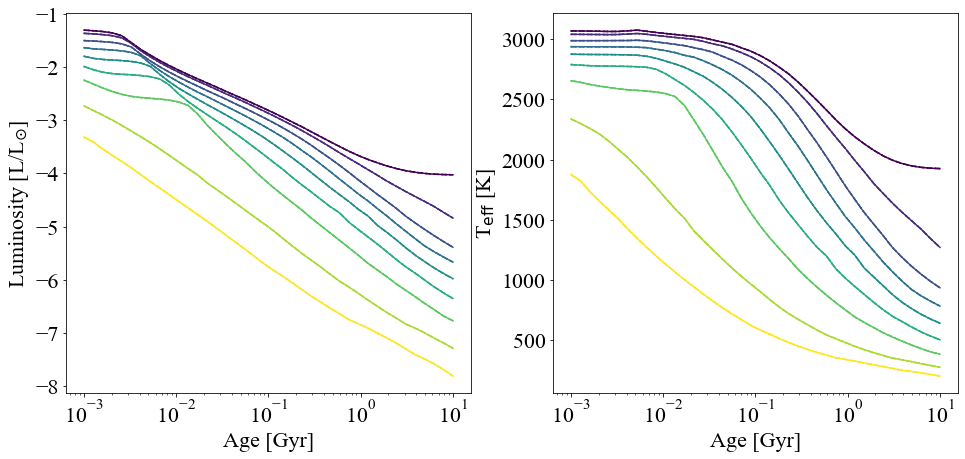

In [81]:
fig, ax = plt.subplots(1, 2, figsize=(16, 7))

i     = 0
ls    = ["-", "--", ":"]



models = ["ATMO_CEQ/", "ATMO_NEQ_strong/", "ATMO_NEQ_weak/"]
masses = [0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.075]
color  = bokeh.palettes.viridis(len(masses))
color  = color[::-1]

for model in models:
    j = 0
    for mass in masses:
        #if (np.abs(mass-0.06) < 0.009) or (np.abs(mass-0.07) < 0.009):
        #    print(mass)
        #    continue
        ax[0].plot(evolution_ATMO20[model][mass][0], evolution_ATMO20[model][mass][2], ls=ls[i], color=color[j])
        ax[1].plot(evolution_ATMO20[model][mass][0], evolution_ATMO20[model][mass][1], ls=ls[i], color=color[j])
        j = j+1
    i = i+1
        
ax[0].set_xlabel("Age [Gyr]")
ax[0].set_xscale("log")
ax[0].set_ylabel(r"Luminosity [L/L$_{\odot}$]")
ax[1].set_xlabel("Age [Gyr]")
ax[1].set_xscale("log")
ax[1].set_ylabel(r"T$_{\rm eff}$ [K]")

**L <--> Teff mapping**

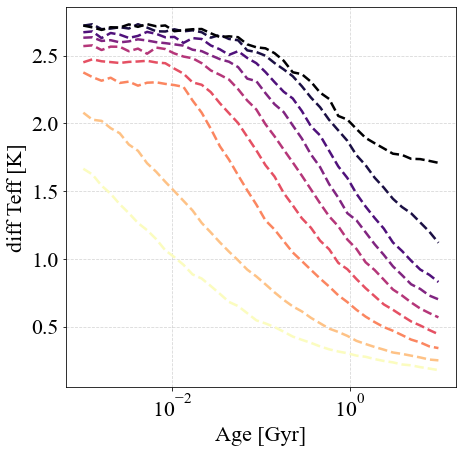

In [141]:
models = ["ATMO_CEQ/"]#, "ATMO_NEQ_strong/", "ATMO_NEQ_weak/"]
masses = [0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.075]
T      = {}
colors = bokeh.palettes.magma(len(M))
colors = colors[::-1]

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

for model in models:
    i = 0
    for mass in masses:
        T[mass] = temperature(10**evolution_ATMO20[model][mass][2]*L_sun.value, evolution_ATMO20[model][mass][3]*R_sun.value)
        ax.plot(evolution_ATMO20[model][mass][0], evolution_ATMO20[model][mass][1]-T[mass].value, color=colors[i], lw=2.5, ls="--")
        #ax.plot(evolution_ATMO20[model][mass][0], T[mass], color=colors[i], lw=2.5, ls="--")
        i = i+1
        
ax.set_ylabel("diff Teff [K]")
ax.set_xlabel("Age [Gyr]")
ax.grid(which="both", ls="--", alpha=0.5)
#ax.set_ylim([0, 8000])
ax.set_xscale("log")

[0.01, 0.03, 0.05]


(100.0, 1600.0)

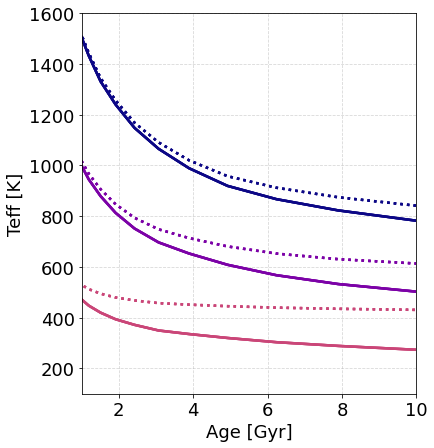

In [113]:
fig, ax = plt.subplots(1, 1, figsize=(6, 7))



from utils import temperature_withDM


M = [0.01, 0.03, 0.05]
print(M)

colors = bokeh.palettes.plasma(len(M)+2)
colors = colors[::-1] # reverse tuple
model  = "ATMO_CEQ/"

i = 2
for mass in M:

    for model in models:
        ax.plot(evolution_ATMO20[model][mass][0], evolution_ATMO20[model][mass][1], color=colors[i], lw=2.5, ls="-")
        
        mass_in_kg = mass*M_sun.value
        ax.plot(evolution_ATMO20[model][mass][0], temperature_withDM(0.1, evolution_ATMO20[model][mass][1], 
                                                                     M=mass_in_kg, v=100.), 
               color=colors[i], lw=2.5, ls=":")
    
    
    i = i+1


ax.set_ylabel("Teff [K]")
ax.set_xlabel("Age [Gyr]")
ax.grid(which="both", ls="--", alpha=0.5)
ax.set_xlim([1, 10])
ax.set_ylim([100, 1600])

## Sonora bobcat

In [26]:
!ls /home/mariacst/exoplanets/exoplanets/data/evolution_models/sonora_bobcat/evolution_tables/evo_tables+0.0

nc+0.0_co1.0_age  nc+0.0_co1.0_lbol  nc+0.0_co1.0_mass	nc+0.0_co1.0_mass_age


In [86]:
path = "/home/mariacst/exoplanets/exoplanets/data/evolution_models/"

MH = 0.

filename = (path + "sonora_bobcat/evolution_tables/evo_tables+%.1f/nc+0.0_co1.0_mass" %MH)


mass = []
age  = []
logL = []
Teff = []
R    = []

with open(filename,"r") as f:
    i = 0
    for x in f.readlines():
        if i==0:
            i += 1
            continue
        if len(x.split())==1:
            continue
        else:
            data = x.split()
            mass.append(float(data[0]))
            age.append(float(data[1]))
            logL.append(float(data[2]))
            Teff.append(float(data[3]))
            R.append(float(data[5]))
            
# initialise data of lists.
data = {'mass':mass,
        'age':age,
        'Teff':Teff,
        'radius':R}
 
# Create DataFrame
df = pd.DataFrame(data)

In [61]:
df.mass.unique()

array([0.0005, 0.001 , 0.0015, 0.002 , 0.0025, 0.003 , 0.0035, 0.004 ,
       0.0045, 0.005 , 0.006 , 0.007 , 0.008 , 0.009 , 0.01  , 0.011 ,
       0.0115, 0.012 , 0.0125, 0.013 , 0.0135, 0.014 , 0.0145, 0.015 ,
       0.0155, 0.016 , 0.0165, 0.017 , 0.0175, 0.018 , 0.0185, 0.019 ,
       0.0195, 0.02  , 0.022 , 0.024 , 0.026 , 0.028 , 0.03  , 0.033 ,
       0.035 , 0.038 , 0.04  , 0.043 , 0.045 , 0.048 , 0.05  , 0.053 ,
       0.055 , 0.058 , 0.06  , 0.063 , 0.064 , 0.065 , 0.066 , 0.067 ,
       0.068 , 0.069 , 0.07  , 0.071 , 0.072 , 0.073 , 0.074 , 0.075 ,
       0.077 , 0.078 , 0.08  ])

In [64]:
df[np.abs(df["mass"]-0.01)<1e-4]

,mass,age,Teff,radius
397,0.01,0.001,2368.0,0.2563
398,0.01,0.002,2234.0,0.2137
399,0.01,0.003,2125.0,0.1941
400,0.01,0.004,2035.0,0.1819
401,0.01,0.006,1901.0,0.1676
402,0.01,0.008,1794.0,0.1591
403,0.01,0.010,1706.0,0.1534
404,0.01,0.015,1546.0,0.1451
405,0.01,0.020,1436.0,0.1399
406,0.01,0.030,1298.0,0.1341


[0.01, 0.03, 0.05]


(100.0, 1600.0)

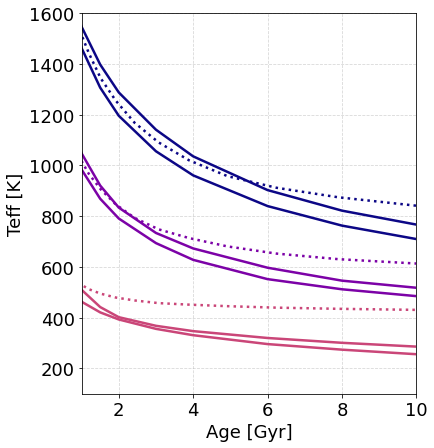

In [114]:
fig, ax = plt.subplots(1, 1, figsize=(6, 7))



from utils import temperature_withDM


M = [0.01, 0.03, 0.05]
print(M)

colors = bokeh.palettes.plasma(len(M)+2)
colors = colors[::-1] # reverse tuple
model  = "ATMO_CEQ/"

i = 2
for mass in M:

    ax.plot(df[np.abs(df["mass"]-mass)<1e-4].age, df[np.abs(df["mass"]-mass)<1e-4].Teff, color=colors[i], lw=2.5, ls="-")
    
    mass_in_kg = mass*M_sun.value
    ax.plot(evolution_ATMO20[model][mass][0], temperature_withDM(0.1, evolution_ATMO20[model][mass][1], 
                                                                 M=mass_in_kg, v=100.), 
           color=colors[i], lw=2.5, ls=":")
    
    ax.plot(df1[np.abs(df1["mass"]-mass)<1e-4].age, df1[np.abs(df1["mass"]-mass)<1e-4].Teff, color=colors[i], lw=2.5, ls="-")

    
    i = i+1


ax.set_ylabel("Teff [K]")
ax.set_xlabel("Age [Gyr]")
ax.grid(which="both", ls="--", alpha=0.5)
ax.set_xlim([1, 10])
ax.set_ylim([100, 1600])

## Anlytical model

In [3]:
from mpmath import polylog

def psi_Auddy(t, M):
    """
    Time evolution of Psi as given by Auddy et al. 2016 (eq. 47) (for Psi << 1)
    
    Input
    -----
        t : time [years]
        M : mass [Msun]
        
    Output
    ------
        Psi: degeneracy
    """
    return np.power(317.8 + 2.053e-6*np.power(M, -1.094)*t, -0.2794)

def Teff_Auddy(psi, M, mu_e, mu, kR):
    """
    Effective temperature evolution (eq. 31 Auddy et al. 2016)
    Input
    -----
        psi : degeneracy parameter
        M   : mass [Msun]
        
    Output
    ------
        Teff : effective temperature [K]
    
    """
    a = 5*mu_e/2./mu
    b = (-5./16.*psi*np.log(1+np.exp(-1./psi)) + 15./8.*psi*psi*(np.pi**2/3. + polylog(2, -np.exp(-1./psi))))
    
    return 2.57881e4*np.power(kR, -0.2856)*np.power(M, 0.4764)*np.power(psi, 1.1456)/np.power(1+b+a*psi, 0.5712)

In [4]:
xH = 0.5*0.51; X = 0.75; Y = 0.25;  mu = np.power((1+xH)*X + Y/4., -1); mu_e = np.power(X + Y/2., -1)
kR = 0.01;

In [5]:
t    = np.logspace(6, 10, 100)
M    = 0.03
Psi  = psi_Auddy(t, M)
Teff = []
for _psi in Psi:
    Teff.append(Teff_Auddy(_psi, M, mu_e, mu, kR))
    
t = (t*u.year).to(u.Gyr)

findfont: Font family ['times new roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['times new roman'] not found. Falling back to DejaVu Sans.


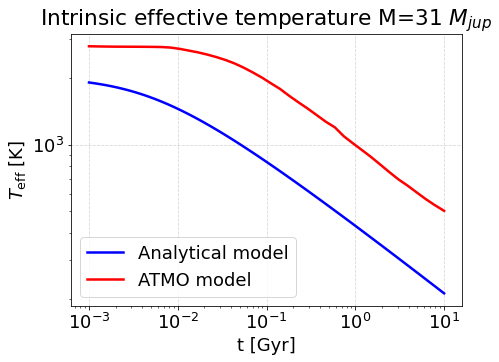

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

ax.plot(t, Teff, lw=2.5, color="blue", label="Analytical model")
ax.plot(evolution_ATMO20[model][M][0], evolution_ATMO20[model][M][1], color="red", lw=2.5, ls="-", label="ATMO model")

ax.legend()
ax.set_title(r"Intrinsic effective temperature M=31 $M_{jup}$")
ax.set_ylabel(r"$T_{\rm eff}$ [K]")
ax.set_xlabel("t [Gyr]")
ax.set_xscale("log"); ax.set_yscale("log")
ax.grid(ls="--", alpha=0.5)
fig.savefig("Teff_analytical_vs_numerical.pdf", bbox_inches="tight")

In [53]:
t    = np.logspace(6, 10, 100)
M    = 0.05
Psi  = psi_Auddy(t, M)
Teff = []
for _psi in Psi:
    Teff.append(Teff_Auddy(_psi, M, mu_e, mu, kR))
    
t = (t*u.year).to(u.Gyr)

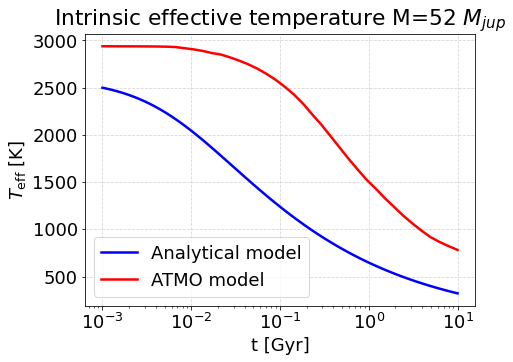

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

ax.plot(t, Teff, lw=2.5, color="blue", label="Analytical model")
ax.plot(evolution_ATMO20[model][M][0], evolution_ATMO20[model][M][1], color="red", lw=2.5, ls="-", label="ATMO model")

ax.legend()
ax.set_title(r"Intrinsic effective temperature M=52 $M_{jup}$")
ax.set_ylabel(r"$T_{\rm eff}$ [K]")
ax.set_xlabel("t [Gyr]")
ax.set_xscale("log")
ax.grid(ls="--", alpha=0.5)

## Comparing models

**Conclusions**

- Systematic uncertainties due to theoretical modelling & BD composition are important for the most massive BDs (these uncertainties are of the same order of the increase in temperature due to DM)
- Systematic uncertainties due to effect of disequilibria in BD atmosphere seems to be unimportant.

dict_keys([0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08])


findfont: Font family ['times new roman'] not found. Falling back to DejaVu Sans.


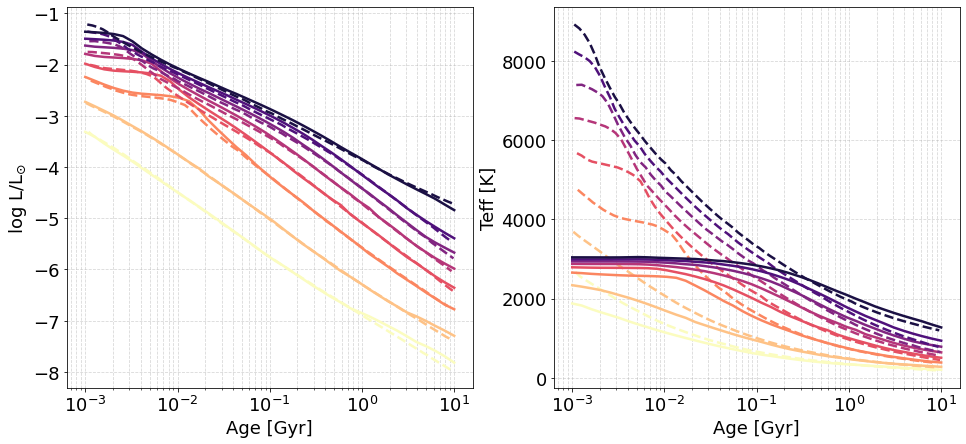

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(16, 7))


M = evolution_SM08.keys()
print(M)

colors = bokeh.palettes.magma(len(M))
colors = colors[::-1] # reverse tuple
model  = "ATMO_CEQ/"

i = 0
for mass in M:
    if np.abs(mass-0.08) < 0.001:
        continue
    ax[0].plot(evolution_SM08[mass][0]/1e9, evolution_SM08[mass][2], color=colors[i], lw=2.5, ls="--")
    ax[1].plot(evolution_SM08[mass][0]/1e9, evolution_SM08[mass][1], color=colors[i], lw=2.5, ls="--")
    try:
        ax[0].plot(evolution_ATMO20[model][mass][0], evolution_ATMO20[model][mass][2], color=colors[i], lw=2.5, ls="-")
        ax[1].plot(evolution_ATMO20[model][mass][0], evolution_ATMO20[model][mass][1], color=colors[i], lw=2.5, ls="-")
    except:
        print(mass)
    i = i+1

ax[0].set_ylabel(r"log L/L$_{\odot}$")
ax[0].set_xlabel("Age [Gyr]")
ax[0].grid(which="both", ls="--", alpha=0.5)
ax[0].set_xscale("log")
#ax[0].set_ylim([-8, -1])
#ax[0].set_xlim([6, 10])

ax[1].set_ylabel("Teff [K]")
ax[1].set_xlabel("Age [Gyr]")
ax[1].grid(which="both", ls="--", alpha=0.5)
#ax[1].set_xlim([6, 10])
ax[1].set_xscale("log")

findfont: Font family ['times new roman'] not found. Falling back to DejaVu Sans.


[0.01, 0.03, 0.05]


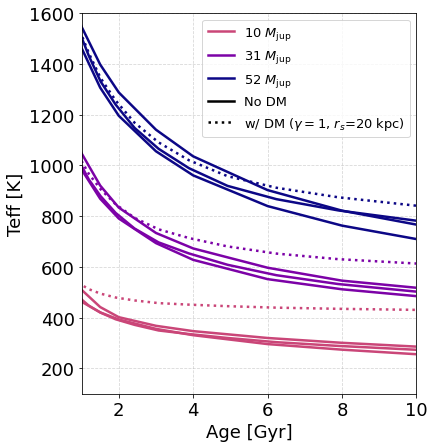

In [109]:
fig, ax = plt.subplots(1, 1, figsize=(6, 7))



from utils import temperature_withDM


M = [0.01, 0.03, 0.05]
print(M)

colors = bokeh.palettes.plasma(len(M)+2)
colors = colors[::-1] # reverse tuple
model  = "ATMO_CEQ/"

i = 2
for mass in M:

    ax.plot(df[np.abs(df["mass"]-mass)<1e-4].age, df[np.abs(df["mass"]-mass)<1e-4].Teff, color=colors[i], lw=2.5, ls="-")
    ax.plot(evolution_ATMO20[model][mass][0], evolution_ATMO20[model][mass][1], color=colors[i], lw=2.5, ls="-")
    
    mass_in_kg = mass*M_sun.value
    ax.plot(evolution_ATMO20[model][mass][0], temperature_withDM(0.1, evolution_ATMO20[model][mass][1], 
                                                                 M=mass_in_kg, v=100.), 
           color=colors[i], lw=2.5, ls=":")
    
    ax.plot(df1[np.abs(df1["mass"]-mass)<1e-4].age, df1[np.abs(df1["mass"]-mass)<1e-4].Teff, color=colors[i], lw=2.5, ls="-")

    
    i = i+1


ax.set_ylabel("Teff [K]")
ax.set_xlabel("Age [Gyr]")
ax.grid(which="both", ls="--", alpha=0.5)
ax.set_xlim([1, 10])
ax.set_ylim([100, 1600])

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=colors[2], ls= "-", lw=2.5),
                Line2D([0], [0], color=colors[3], ls= "-", lw=2.5),
                Line2D([0], [0], color=colors[4], ls= "-", lw=2.5),
                Line2D([0], [0], color="k", ls= "-", lw=2.5),
                Line2D([0], [0], color="k", ls= ":", lw=2.5)]
ax.legend(custom_lines, 
          [r'10 $M_{\rm jup}$', r'31 $M_{\rm jup}$', r'52 $M_{\rm jup}$', 'No DM', r'w/ DM ($\gamma=1$, $r_s$=20 kpc)'],
          fontsize=13)
fig.savefig("Teff_evolution.pdf", bbox_inches="tight")

## Tmin cuts

In [4]:
import mock_generation
imp.reload(mock_generation)

from mock_generation import mock_population

N = 100; gamma=1.5; rs = 20.; f = 1.

robs0, Tobs0_wn, Tobs0, mass0_wn, mass0, ages0 = mock_population(N, 0.10, 0.10, f, gamma, rs, Tmin=650.)
robs1, Tobs1_wn, Tobs1, mass1_wn, mass1, ages1 = mock_population(N, 0.10, 0.20, f, gamma, rs, Tmin=650.)
robs2, Tobs2_wn, Tobs2, mass2_wn, mass2, ages2 = mock_population(N, 0.20, 0.20, f, gamma, rs, Tmin=650.)
robs3, Tobs3_wn, Tobs3, mass3_wn, mass3, ages3 = mock_population(N, 0.30, 0.30, f, gamma, rs, Tmin=650.)

In [5]:
print(np.std((mass0-mass0_wn)/mass0)*100)
print(np.std((mass1-mass1_wn)/mass0)*100)
print(np.std((mass2-mass2_wn)/mass0)*100)

print("")

print(np.std((Tobs0-Tobs0_wn)/Tobs0)*100)
print(np.std((Tobs1-Tobs1_wn)/Tobs0)*100)
print(np.std((Tobs2-Tobs2_wn)/Tobs0)*100)

10.000029417970637
20.469948717208798
23.82697543992639

9.632579734976298
10.493476220007993
20.308365795001475


200.34531482 2205.1801623104056


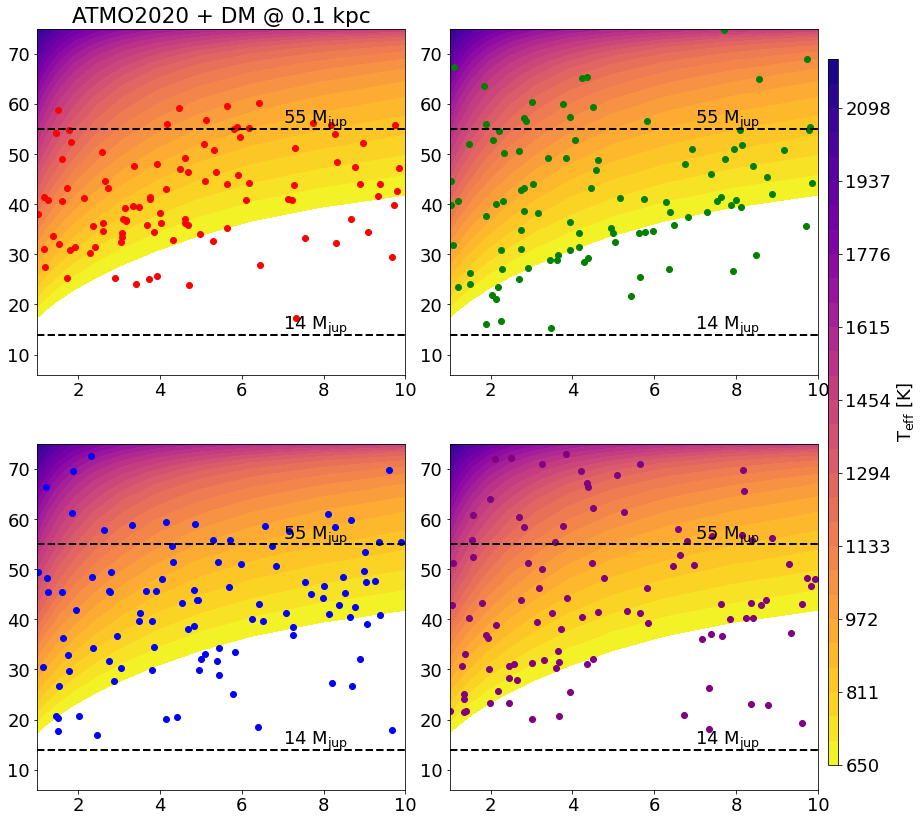

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(14, 14))

Z = _teff.reshape(len(M), len(_age))
M_in_jup = M*M_sun/M_jup
X, Y = np.meshgrid(_age, M_in_jup)

#levels = np.linspace(np.min(_teff), np.max(_teff), 14)
levels = np.linspace(650., np.max(_teff), 30)
print(np.min(_teff), np.max(_teff))
            
ax = axes[0, 0]
heat_int = heat(Z.ravel(), np.ones(len(Z.ravel()))*R_jup.value)
T_DM     = temperature_withDM(1., heat_int, f=1., R=R_jup.value, M=Y.ravel()*M_jup.value, parameters=[1.5, 20., 0.42])
Z_DM     = T_DM.reshape(Z.shape)
ax.set_title("ATMO2020 + DM @ 0.1 kpc")
ax.set_ylim(6, 75)
ax.axhline(14, color="k", ls="--", lw=2.)
ax.text(7., 15, r"14 M$_{\rm jup}$", color="k")
ax.text(7., 56, r"55 M$_{\rm jup}$", color="k")
ax.axhline(55, color="k", ls="--", lw=2.)

im = ax.contourf(X, Y, Z_DM, levels=levels, cmap="plasma_r")
ax.scatter(ages0, mass0*M_sun.value/M_jup.value, color="red")

ax = axes[0, 1]
ax.contourf(X, Y, Z_DM, levels=levels, cmap="plasma_r")
ax.scatter(ages1, mass1*M_sun.value/M_jup.value, color="green")
ax.set_ylim(6, 75)
ax.axhline(14, color="k", ls="--", lw=2.)
ax.text(7., 15., r"14 M$_{\rm jup}$", color="k")
ax.text(7., 56., r"55 M$_{\rm jup}$", color="k")
ax.axhline(55, color="k", ls="--", lw=2.)

ax = axes[1, 0]
ax.contourf(X, Y, Z_DM, levels=levels, cmap="plasma_r")
ax.scatter(ages2, mass2*M_sun.value/M_jup.value, color="blue")
ax.set_ylim(6, 75)
ax.axhline(14, color="k", ls="--", lw=2.)
ax.text(7., 15., r"14 M$_{\rm jup}$", color="k")
ax.text(7., 56., r"55 M$_{\rm jup}$", color="k")
ax.axhline(55, color="k", ls="--", lw=2.)

ax = axes[1, 1]
ax.contourf(X, Y, Z_DM, levels=levels, cmap="plasma_r")
ax.scatter(ages3, mass3*M_sun.value/M_jup.value, color="purple")
ax.set_ylim(6, 75)
ax.axhline(14, color="k", ls="--", lw=2.)
ax.text(7., 15., r"14 M$_{\rm jup}$", color="k")
ax.text(7., 56., r"55 M$_{\rm jup}$", color="k")
ax.axhline(55, color="k", ls="--", lw=2.)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r"T$_{\rm eff}$ [K]")

fig.subplots_adjust(wspace=0.12)

In [7]:
path   = "../data/evolution_models/ATMO_2020_models/evolutionary_tracks/"
models = ["ATMO_CEQ/"]

evolution_ATMO20      = {}
evolution_ATMO20["M"] = []
for model in models:
    evolution_ATMO20[model] = {}
    files = glob.glob(path + model + "*.txt")
    for file in files:
        data = np.genfromtxt(file, unpack=True)
        evolution_ATMO20[model][data[0][0]] = [data[1], data[2], data[3], data[4], data[5]] 
        # age [Gyr] / Teff [K] / L [L/Lsun] / R [R/Rsun] / log g [cm/s2]
        if model==models[0]:
            #print (data[0][0], file)
            evolution_ATMO20["M"].append(data[0][0])

In [8]:
model = "ATMO_CEQ/"
age   = {}
M     = np.sort(evolution_ATMO20["M"])[5:-1]
Teff  = {}

for mass in M:
    age[mass]  = evolution_ATMO20[model][mass][0]
    Teff[mass] = evolution_ATMO20[model][mass][1]

_age   = np.linspace(1, 10, 100)    
_teff  = [] ; _age_i = []; _mass  = []
for m in M:
    Teff_interp = interp1d(age[m], Teff[m])
    for _a in _age:
        _age_i.append(_a)
        _mass.append(m)
        _teff.append(Teff_interp(_a))
        
Teff_interp_2d = interp2d(_age_i, _mass, _teff)
_teff = np.asarray(_teff)

/home/mariacst/exoplanets/.venv/lib64/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=92,80 m=7000 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


200.34531482 2205.1801623104056


findfont: Font family ['times new roman'] not found. Falling back to DejaVu Sans.


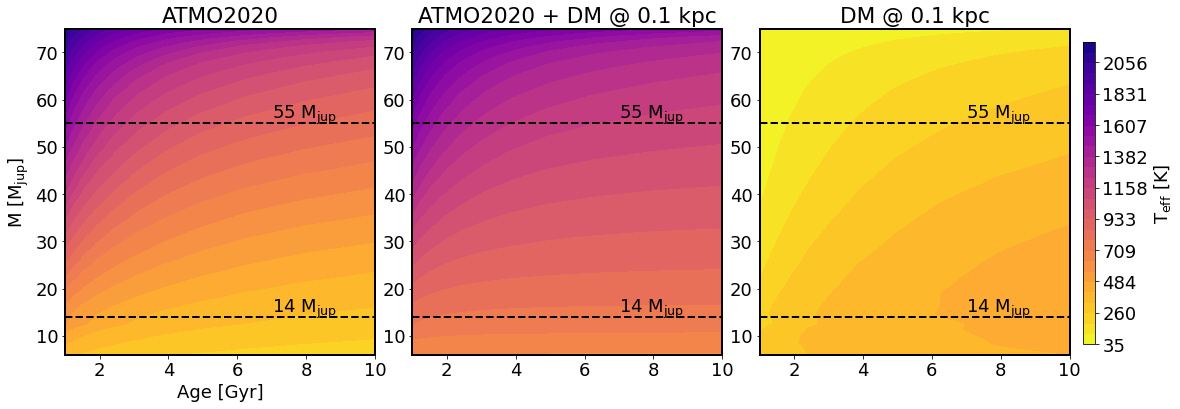

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

Z = _teff.reshape(len(M), len(_age))
M_in_jup = M*M_sun/M_jup
X, Y = np.meshgrid(_age, M_in_jup)

#levels = np.linspace(np.min(_teff), np.max(_teff), 14)
levels = np.linspace(35, np.max(_teff), 30)
print(np.min(_teff), np.max(_teff))

ax = axes[0]
#Z = np.ma.array(Z, mask=Z < 650.)
ax.contourf(X, Y, Z, levels=levels, cmap="plasma_r")
ax.axhline(14, color="k", ls="--", lw=2.)
ax.text(7., 15, r"14 M$_{\rm jup}$", color="k")
ax.text(7., 56, r"55 M$_{\rm jup}$", color="k")
ax.axhline(55, color="k", ls="--", lw=2.)
ax.set_ylabel(r"M [M$_{\rm jup}$]")
ax.set_xlabel("Age [Gyr]")
ax.set_title("ATMO2020")
ax.set_ylim(6, 75)

for ax in axes:
    for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2.)
            
ax = axes[1]
heat_int = heat(Z.ravel(), np.ones(len(Z.ravel()))*R_jup.value)
T_DM     = temperature_withDM(0.1, heat_int, f=1., R=R_jup.value, M=Y.ravel()*M_jup.value, parameters=[1.5, 20., 0.42])
Z_DM     = T_DM.reshape(Z.shape)
ax.set_title("ATMO2020 + DM @ 0.1 kpc")
ax.set_ylim(6, 75)
ax.axhline(14, color="k", ls="--", lw=2.)
ax.text(7., 15, r"14 M$_{\rm jup}$", color="k")
ax.text(7., 56, r"55 M$_{\rm jup}$", color="k")
ax.axhline(55, color="k", ls="--", lw=2.)

ax.contourf(X, Y, Z_DM, levels=levels, cmap="plasma_r")

ax = axes[2]
Z_res = Z_DM-Z
im = ax.contourf(X, Y, Z_res, levels=levels, cmap="plasma_r")
ax.set_title("DM @ 0.1 kpc")
ax.set_ylim(6, 75)
ax.axhline(14, color="k", ls="--", lw=2.)
ax.text(7., 15., r"14 M$_{\rm jup}$", color="k")
ax.text(7., 56., r"55 M$_{\rm jup}$", color="k")
ax.axhline(55, color="k", ls="--", lw=2.)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r"T$_{\rm eff}$ [K]")

fig.subplots_adjust(wspace=0.12)

In [ ]:
/hdfs/local/mariacst/exoplanets/results/final_round/Tmin/ex12

In [ ]:
/hdfs/local/mariacst/exoplanets/results/final_round/Tmin/ex12

200.34531482 2205.1801623104056


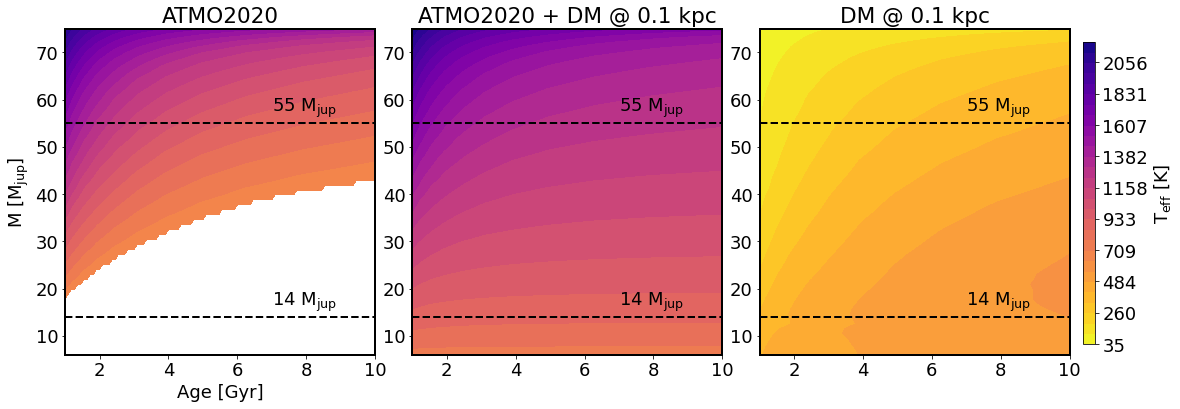

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

Z = _teff.reshape(len(M), len(_age))
M_in_jup = M*M_sun/M_jup
X, Y = np.meshgrid(_age, M_in_jup)

#levels = np.linspace(np.min(_teff), np.max(_teff), 14)
levels = np.linspace(35, np.max(_teff), 30)
print(np.min(_teff), np.max(_teff))

ax = axes[0]
Z_mask = np.ma.array(Z, mask=Z < 650.)
ax.contourf(X, Y, Z_mask, levels=levels, cmap="plasma_r")
ax.axhline(14, color="k", ls="--", lw=2.)
ax.text(7., 16.5, r"14 M$_{\rm jup}$", color="k")
ax.text(7., 57.5, r"55 M$_{\rm jup}$", color="k")
ax.axhline(55, color="k", ls="--", lw=2.)
ax.set_ylabel(r"M [M$_{\rm jup}$]")
ax.set_xlabel("Age [Gyr]")
ax.set_title("ATMO2020")
ax.set_ylim(6, 75)

for ax in axes:
    for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2.)
            
ax = axes[1]
heat_int = heat(Z.ravel(), np.ones(len(Z.ravel()))*R_jup.value)
T_DM     = temperature_withDM(0.1, heat_int, f=1., R=R_jup.value, M=Y.ravel()*M_jup.value, parameters=[1.5, 5., 0.42])
Z_DM     = T_DM.reshape(Z.shape)
ax.set_title("ATMO2020 + DM @ 0.1 kpc")
ax.set_ylim(6, 75)
ax.axhline(14, color="k", ls="--", lw=2.)
ax.text(7., 16.5, r"14 M$_{\rm jup}$", color="k")
ax.text(7., 57.5, r"55 M$_{\rm jup}$", color="k")
ax.axhline(55, color="k", ls="--", lw=2.)

Z_DM_mask = np.ma.array(Z_DM, mask=Z_DM < 650.)
ax.contourf(X, Y, Z_DM_mask, levels=levels, cmap="plasma_r")

ax = axes[2]
Z_res = Z_DM-Z
im = ax.contourf(X, Y, Z_res, levels=levels, cmap="plasma_r")
ax.set_title("DM @ 0.1 kpc")
ax.set_ylim(6, 75)
ax.axhline(14, color="k", ls="--", lw=2.)
ax.text(7., 16.5, r"14 M$_{\rm jup}$", color="k")
ax.text(7., 57.5, r"55 M$_{\rm jup}$", color="k")
ax.axhline(55, color="k", ls="--", lw=2.)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r"T$_{\rm eff}$ [K]")

fig.subplots_adjust(wspace=0.12)

200.34531482 2205.1801623104056


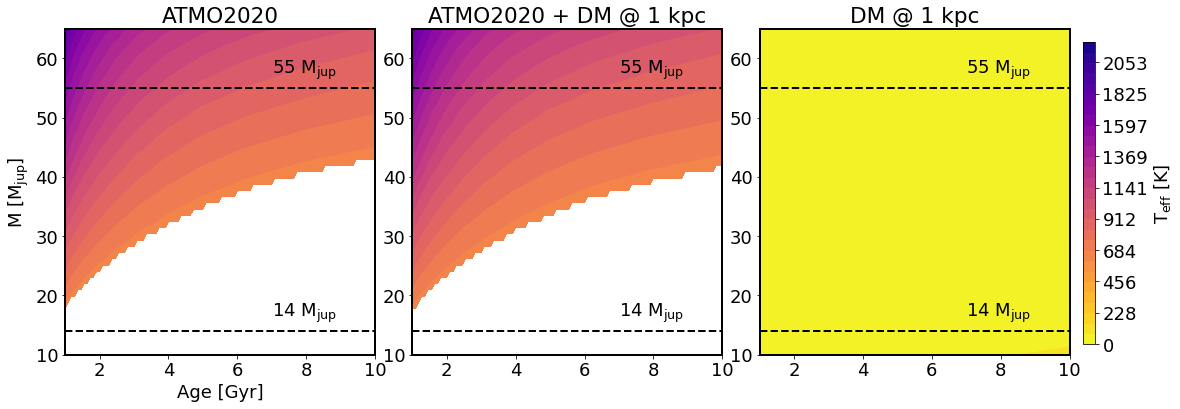

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

Z = _teff.reshape(len(M), len(_age))
M_in_jup = M*M_sun/M_jup
X, Y = np.meshgrid(_age, M_in_jup)

#levels = np.linspace(np.min(_teff), np.max(_teff), 14)
levels = np.linspace(0, np.max(_teff), 30)
print(np.min(_teff), np.max(_teff))

ax = axes[0]
Z_mask = np.ma.array(Z, mask=Z < 650.)
ax.contourf(X, Y, Z_mask, levels=levels, cmap="plasma_r")
ax.axhline(14, color="k", ls="--", lw=2.)
ax.text(7., 16.5, r"14 M$_{\rm jup}$", color="k")
ax.text(7., 57.5, r"55 M$_{\rm jup}$", color="k")
ax.axhline(55, color="k", ls="--", lw=2.)
ax.set_ylabel(r"M [M$_{\rm jup}$]")
ax.set_xlabel("Age [Gyr]")
ax.set_title("ATMO2020")
ax.set_ylim(10, 65)

for ax in axes:
    for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2.)
            
ax = axes[1]
heat_int = heat(Z.ravel(), np.ones(len(Z.ravel()))*R_jup.value)
T_DM     = temperature_withDM(1., heat_int, f=1., R=R_jup.value, M=Y.ravel()*M_jup.value, parameters=[1.5, 5., 0.42])
Z_DM     = T_DM.reshape(Z.shape)
ax.set_title("ATMO2020 + DM @ 1 kpc")
ax.set_ylim(10, 65)
ax.axhline(14, color="k", ls="--", lw=2.)
ax.text(7., 16.5, r"14 M$_{\rm jup}$", color="k")
ax.text(7., 57.5, r"55 M$_{\rm jup}$", color="k")
ax.axhline(55, color="k", ls="--", lw=2.)

Z_DM_mask = np.ma.array(Z_DM, mask=Z_DM < 650.)
ax.contourf(X, Y, Z_DM_mask, levels=levels, cmap="plasma_r")

ax = axes[2]
Z_res = Z_DM-Z
im = ax.contourf(X, Y, Z_res, levels=levels, cmap="plasma_r")
ax.set_title("DM @ 1 kpc")
ax.set_ylim(10, 65)
ax.axhline(14, color="k", ls="--", lw=2.)
ax.text(7., 16.5, r"14 M$_{\rm jup}$", color="k")
ax.text(7., 57.5, r"55 M$_{\rm jup}$", color="k")
ax.axhline(55, color="k", ls="--", lw=2.)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r"T$_{\rm eff}$ [K]")

fig.subplots_adjust(wspace=0.12)

200.34531482 2205.1801623104056


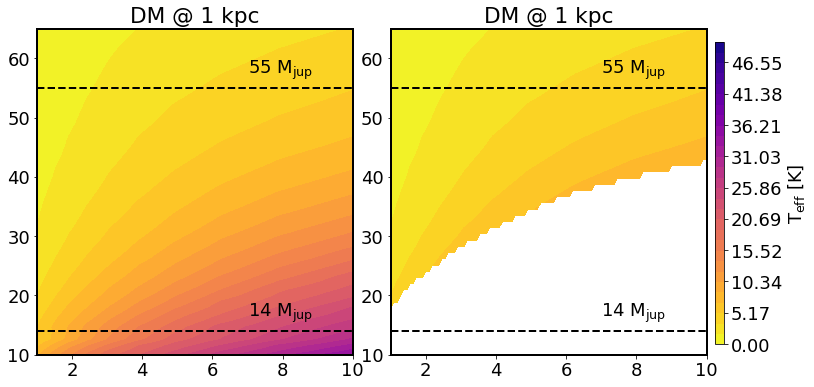

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

Z = _teff.reshape(len(M), len(_age))
M_in_jup = M*M_sun/M_jup
X, Y = np.meshgrid(_age, M_in_jup)

#levels = np.linspace(np.min(_teff), np.max(_teff), 14)
levels = np.linspace(0, 50., 30)
print(np.min(_teff), np.max(_teff))

ax = axes[0]

heat_int  = heat(Z.ravel(), np.ones(len(Z.ravel()))*R_jup.value)
T_DM      = temperature_withDM(1., heat_int, f=1., R=R_jup.value, M=Y.ravel()*M_jup.value, parameters=[1.3, 20., 0.42])
Z_DM      = T_DM.reshape(Z.shape)
Z_DM_mask = np.ma.array(Z_DM, mask=Z_DM < 650.)

Z_res = Z_DM-Z
im = ax.contourf(X, Y, Z_res, levels=levels, cmap="plasma_r")
ax.set_title("DM @ 1 kpc")
ax.set_ylim(10, 65)
ax.axhline(14, color="k", ls="--", lw=2.)
ax.text(7., 16.5, r"14 M$_{\rm jup}$", color="k")
ax.text(7., 57.5, r"55 M$_{\rm jup}$", color="k")
ax.axhline(55, color="k", ls="--", lw=2.)

for ax in axes:
    for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2.)
            
ax = axes[1]
Z_res = Z_DM_mask-Z
im = ax.contourf(X, Y, Z_res, levels=levels, cmap="plasma_r")
ax.set_title("DM @ 1 kpc")
ax.set_ylim(10, 65)
ax.axhline(14, color="k", ls="--", lw=2.)
ax.text(7., 16.5, r"14 M$_{\rm jup}$", color="k")
ax.text(7., 57.5, r"55 M$_{\rm jup}$", color="k")
ax.axhline(55, color="k", ls="--", lw=2.)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r"T$_{\rm eff}$ [K]")

fig.subplots_adjust(wspace=0.12)